<a href="https://colab.research.google.com/github/shalini2006-tech-28/zidio-development/blob/main/TIMESERIES_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance pandas numpy matplotlib seaborn statsmodels scikit-learn tensorflow keras prophet --quiet

Importing the required modules

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import warnings
from prophet import Prophet
import plotly.graph_objects as go
from plotly.subplots import make_subplots

Downloading the data set using yfinance

In [ ]:
data = yf.download('AAPL', start='2018-01-01', end='2023-12-31')
data.reset_index(inplace=True)
print(data.head(),'\n')

series = data[['Close']]
series.dropna(inplace=True)
print(data.head())


/tmp/ipython-input-2-2602951574.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('AAPL', start='2018-01-01', end='2023-12-31')
[*********************100%***********************]  1 of 1 completed

Price        Date      Close       High        Low       Open     Volume
Ticker                  AAPL       AAPL       AAPL       AAPL       AAPL
0      2018-01-02  40.426815  40.436204  39.722760  39.933979  102223600
1      2018-01-03  40.419781  40.964251  40.356418  40.490187  118071600
2      2018-01-04  40.607521  40.710783  40.384571  40.492524   89738400
3      2018-01-05  41.069855  41.156687  40.612220  40.703747   94640000
4      2018-01-08  40.917316  41.213018  40.818746  40.917316   82271200 

Price        Date      Close       High        Low       Open     Volume
Ticker                  AAPL       AAPL       AAPL       AAPL       AAPL
0      2018-01-02  40.426815  40.436204  39.722760  39.933979  102223600
1      2018-01-03  40.419781  40.964251  40.356418  40.490187  118071600
2      2018-01-04  40.607521  40.710783  40.384571  40.492524   89738400
3      2018-01-05  41.069855  41.156687  40.612220  40.703747   94640000
4      2018-01-08  40.917316  41.213018  40.81874


/tmp/ipython-input-2-2602951574.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series.dropna(inplace=True)


Visualizing the dataset using the close price of the stock

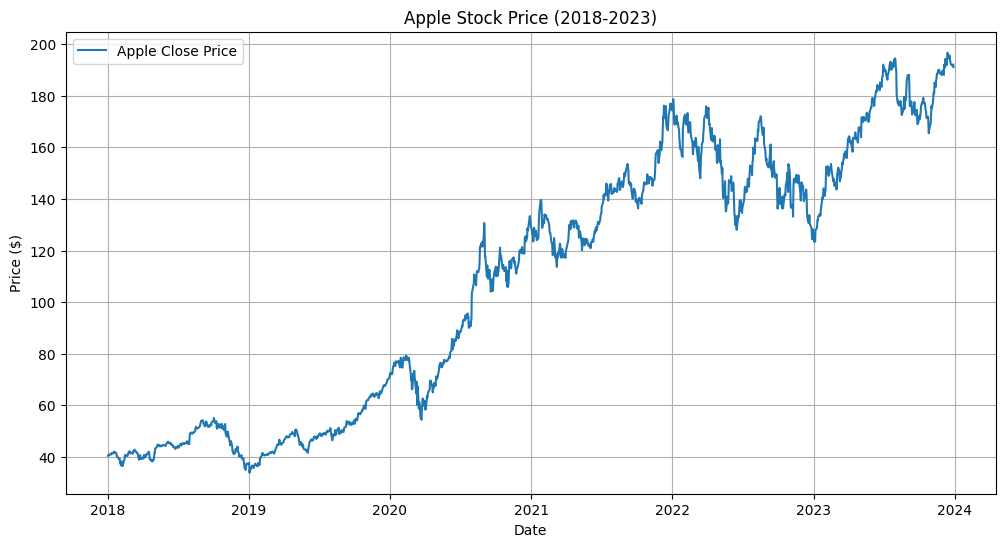

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(data['Date'],series, label='Apple Close Price')
plt.title('Apple Stock Price (2018-2023)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
result = adfuller(series)
if result[1] > 0.05:
    print("Series not stationary → Differencing applied")
    series = series.diff().dropna()


Series not stationary → Differencing applied


ARIMA Model

                               SARIMAX Results                                
Dep. Variable:                   AAPL   No. Observations:                 1509
Model:                 ARIMA(5, 1, 2)   Log Likelihood               -3293.117
Date:                Thu, 24 Jul 2025   AIC                           6602.234
Time:                        12:24:30   BIC                           6644.783
Sample:                             0   HQIC                          6618.081
                               - 1509                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.8627      0.027    -69.262      0.000      -1.915      -1.810
ar.L2         -1.0289      0.046    -22.458      0.000      -1.119      -0.939
ar.L3         -0.0930      0.047     -1.989      0.0

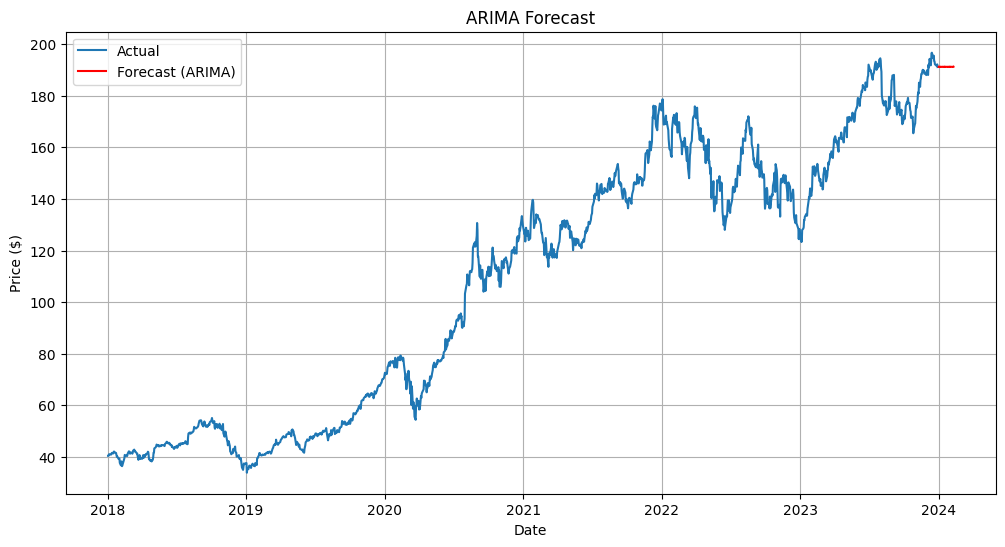

In [ ]:
series = data['Close']

model = ARIMA(series, order=(5,1,2))
warnings.filterwarnings("ignore")
model_fit = model.fit()
print(model_fit.summary())
forecast = model_fit.forecast(steps=30)
print("\nStock forecast prediction for next 30 days\n",forecast)

last_date = data['Date'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='B')

plt.figure(figsize=(12, 6))
plt.plot(data['Date'],series, label='Actual')
plt.plot(future_dates, forecast, label='Forecast (ARIMA)', color='red')
plt.legend()
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(True)
plt.show()

actual = series[-30:].values
predicted = model_fit.predict(start=len(series)-30, end=len(series)-1).values

rmse1 = np.sqrt(mean_squared_error(actual, predicted))
mae1= mean_absolute_error(actual, predicted)
mape1 = np.mean(np.abs((actual - predicted) / actual)) * 100

SARIMA Model

                                     SARIMAX Results                                      
Dep. Variable:                               AAPL   No. Observations:                 1509
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -3308.780
Date:                            Thu, 24 Jul 2025   AIC                           6627.561
Time:                                    12:31:36   BIC                           6654.113
Sample:                                         0   HQIC                          6637.454
                                           - 1509                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4328      0.339      1.278      0.201      -0.231       1.097
ma.L1         -0.4738      0.333   

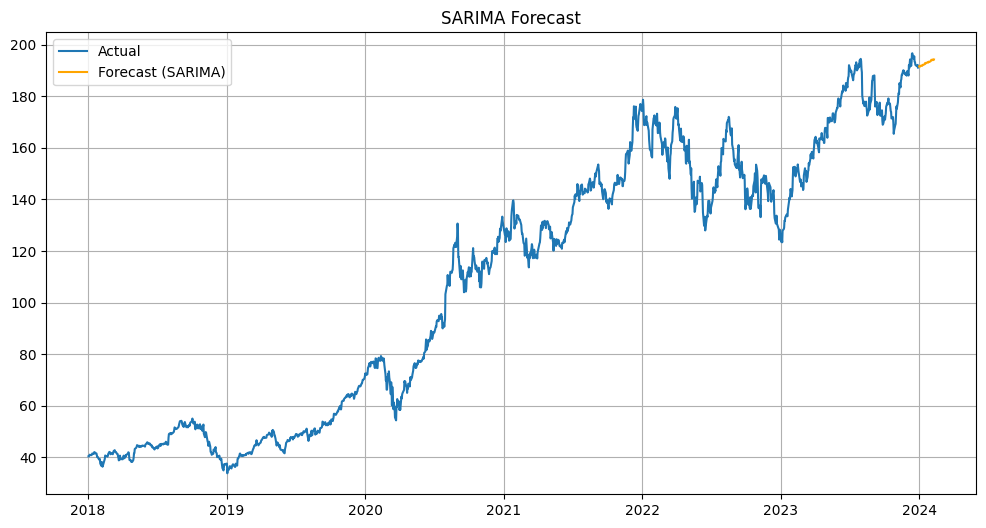

In [ ]:
model_sarima = SARIMAX(series, order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_fit = model_sarima.fit()
print(sarima_fit.summary())
sarima_forecast = sarima_fit.forecast(steps=30)
print("\nStock forecast prediction for next 30 days\n",sarima_forecast)
last_date = data['Date'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='B')

plt.figure(figsize=(12, 6))
plt.plot(data['Date'],series, label='Actual')
plt.plot(future_dates, sarima_forecast, label='Forecast (SARIMA)', color='orange')
plt.legend()
plt.title('SARIMA Forecast')
plt.grid(True)
plt.show()

actual = series[-30:].values
predicted = sarima_fit.predict(start=len(series)-30, end=len(series)-1).values

rmse2 = np.sqrt(mean_squared_error(actual, predicted))
mae2 = mean_absolute_error(actual, predicted)
mape2 = np.mean(np.abs((actual - predicted) / actual)) * 100

LSTM Model

[*********************100%***********************]  1 of 1 completed


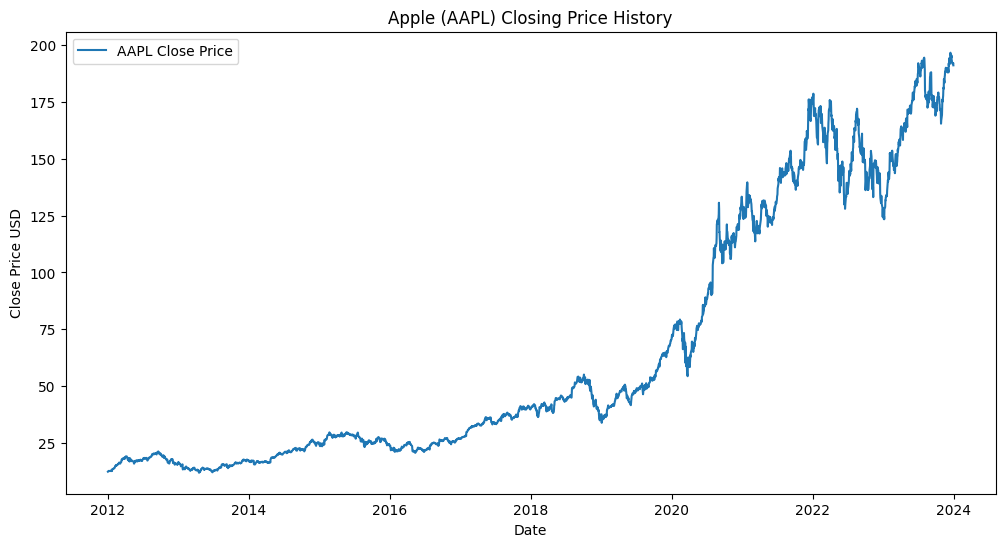

Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - loss: 0.0162
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 2.2209e-04
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 1.7826e-04
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 1.6843e-04
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 1.6083e-04
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 1.6155e-04
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 1.3558e-04
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 1.4124e-04
Epoch 9/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 1.4617e-04
Epoch 10/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 1.4570e-04
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


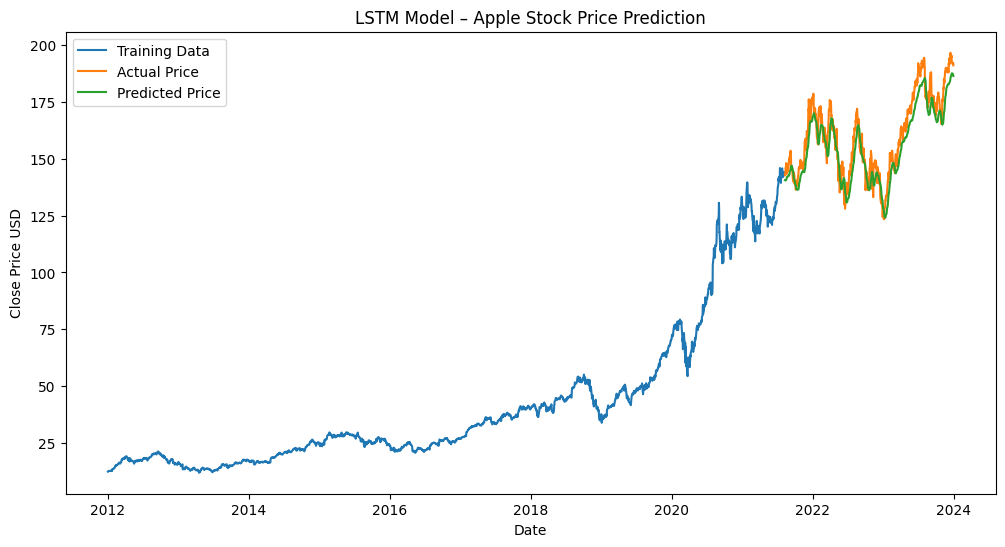

In [ ]:
df = yf.download('AAPL', start='2012-01-01', end='2023-12-31')
data = df[['Close']]

plt.figure(figsize=(12, 6))
plt.plot(data, label='AAPL Close Price')
plt.title('Apple (AAPL) Closing Price History')
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.legend()
plt.show()

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

training_data_len = int(np.ceil(len(scaled_data) * 0.8))
train_data = scaled_data[0:training_data_len, :]

x_train, y_train = [], []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=32, epochs=10)

test_data = scaled_data[training_data_len - 60:, :]
x_test, y_test = [], data[training_data_len:].values

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(12, 6))
plt.title('LSTM Model – Apple Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(train['Close'], label='Training Data')
plt.plot(valid['Close'], label='Actual Price')
plt.plot(valid['Predictions'], label='Predicted Price')
plt.legend()
plt.show()

rmse4 = np.sqrt(mean_squared_error(y_test, predictions))
mae4 = mean_absolute_error(y_test, predictions)
mape4 = np.mean(np.abs((y_test - predictions.flatten()) / y_test)) * 100



Prophet Model

In [ ]:
data = yf.download('AAPL', start='2018-01-01', end='2023-12-31')

[*********************100%***********************]  1 of 1 completed


In [ ]:
df_prophet = data[['Close']].copy()
df_prophet.reset_index(inplace=True)

df_prophet = df_prophet[['Date', 'Close']]
df_prophet.columns = ['ds', 'y']

df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

print(df_prophet.head())
print(df_prophet.dtypes)


          ds          y
0 2018-01-02  40.426815
1 2018-01-03  40.419781
2 2018-01-04  40.607521
3 2018-01-05  41.069855
4 2018-01-08  40.917316
ds    datetime64[ns]
y            float64
dtype: object


In [ ]:
model = Prophet()
model.fit(df_prophet)

future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

actual = df_prophet['y'].iloc[-30:].values
predicted = forecast['yhat'].iloc[-30:].values

rmse3 = np.sqrt(mean_squared_error(actual, predicted))
mae3 = mean_absolute_error(actual, predicted)
mape3 = np.mean(np.abs((actual - predicted) / actual)) * 100


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvayvdsqs/bzu952vn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvayvdsqs/62jn2c04.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20552', 'data', 'file=/tmp/tmpvayvdsqs/bzu952vn.json', 'init=/tmp/tmpvayvdsqs/62jn2c04.json', 'output', 'file=/tmp/tmpvayvdsqs/prophet_model58efkdf1/prophet_model-20250724140219.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:02:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:02:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


             ds        yhat  yhat_lower  yhat_upper
1534 2024-01-24  193.717995  184.729002  202.944329
1535 2024-01-25  193.970651  185.042044  202.790051
1536 2024-01-26  194.248218  184.579399  202.917076
1537 2024-01-27  193.054800  184.504168  201.555374
1538 2024-01-28  193.424402  184.918450  201.556831


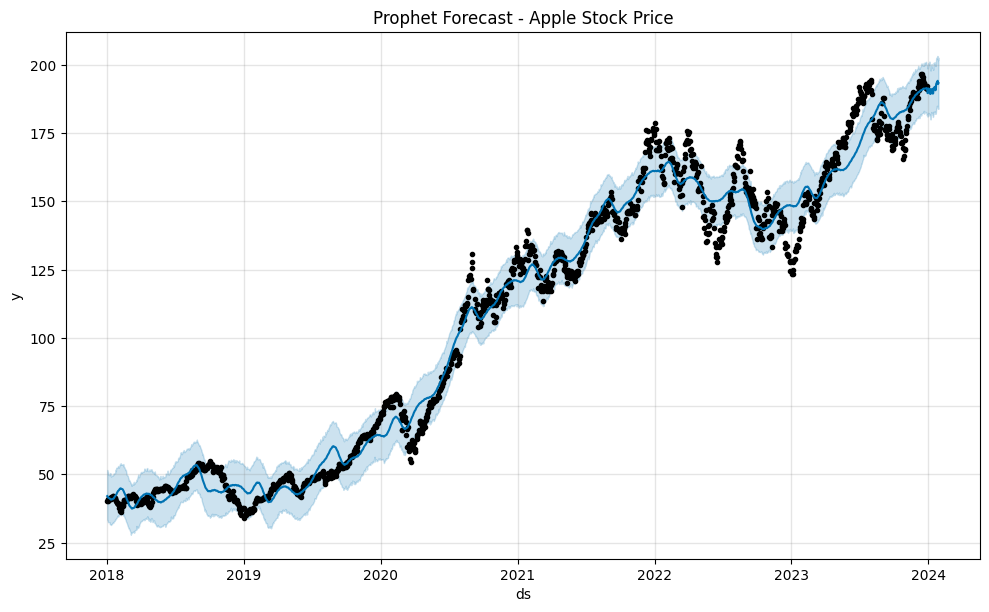

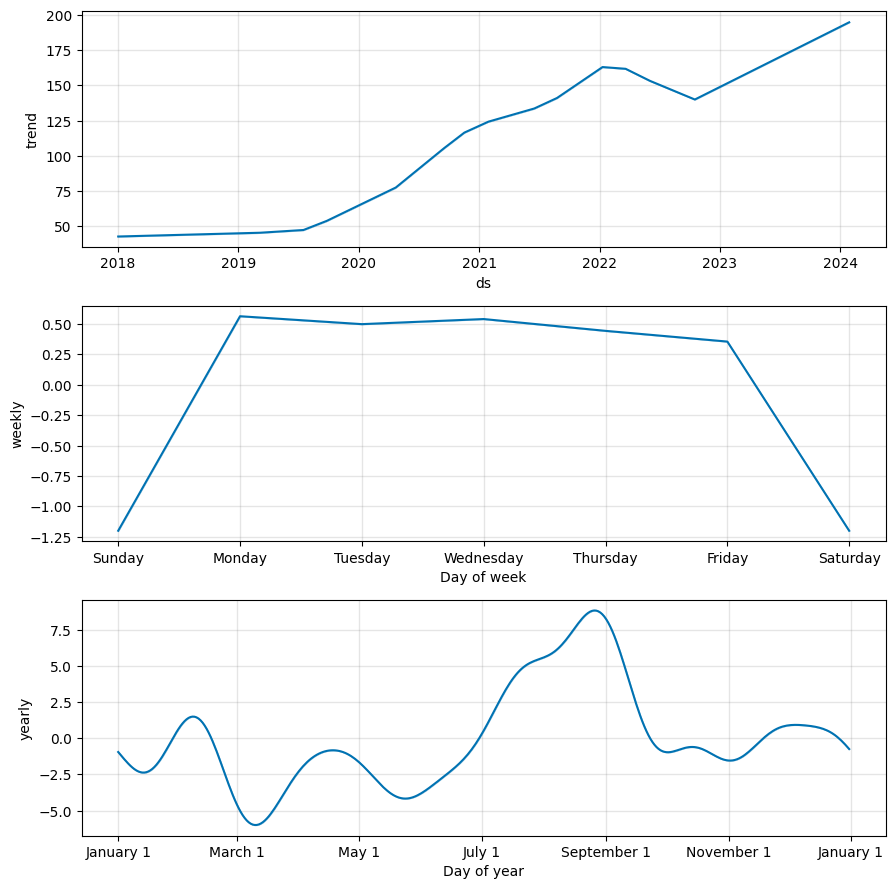

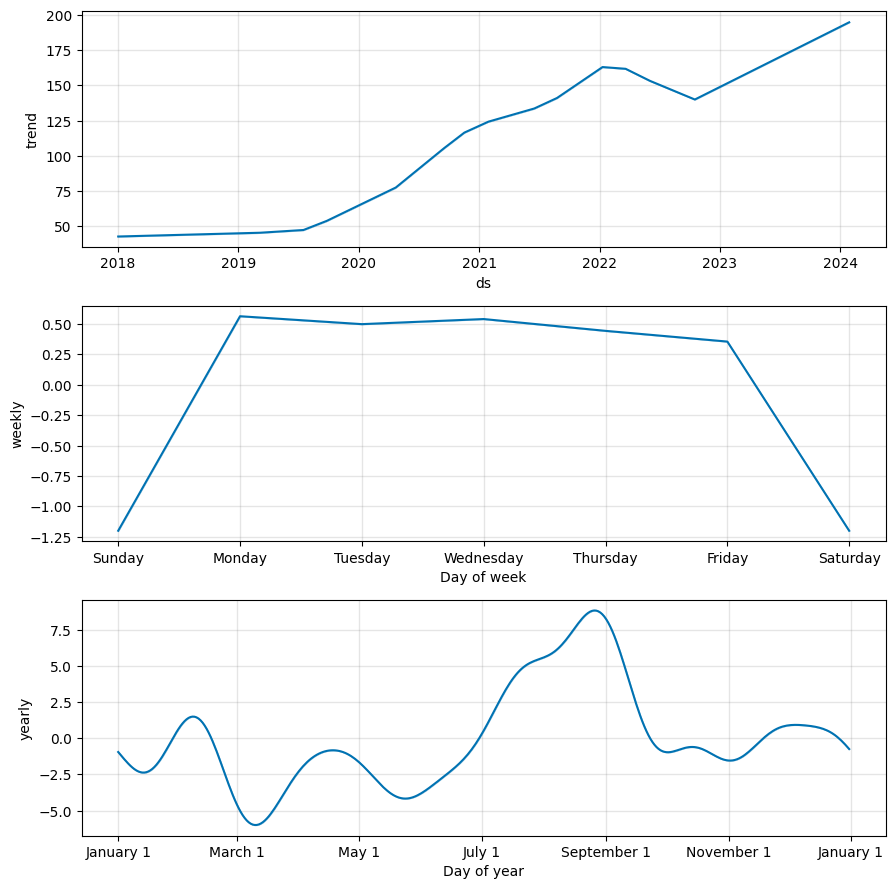

In [ ]:
fig = model.plot(forecast)
plt.title('Prophet Forecast - Apple Stock Price')
plt.grid(True)
plt.show()

model.plot_components(forecast)

Dashboard to compare accuracy of all the models

In [ ]:
models = ["ARIMA", "SARIMA", "Prophet", "LSTM"]

rmse = [rmse1, rmse2, rmse3, rmse4]
mae = [mae1, mae2, mae3, mae4]
mape = [mape1, mape2, mape3, mape4]

fig = make_subplots(
    rows=2, cols=1,
    row_heights=[0.7, 0.3],
    specs=[[{"type": "bar"}],
           [{"type": "table"}]],
    vertical_spacing=0.15,
    subplot_titles=("Model Accuracy Comparison", "Detailed Metrics Table")
)

fig.add_trace(go.Bar(
    x=models, y=rmse, name="RMSE",
    marker_color='#636EFA',
    text=[f"{v:.2f}" for v in rmse], textposition='auto'
), row=1, col=1)

fig.add_trace(go.Bar(
    x=models, y=mae, name="MAE",
    marker_color='#EF553B',
    text=[f"{v:.2f}" for v in mae], textposition='auto'
), row=1, col=1)

fig.add_trace(go.Bar(
    x=models, y=mape, name="MAPE (%)",
    marker_color='#00CC96',
    text=[f"{v:.2f}%" for v in mape], textposition='auto'
), row=1, col=1)

fig.add_trace(go.Table(
    header=dict(values=["Model", "RMSE", "MAE", "MAPE (%)"],
                fill_color='lightgrey', align='center', font=dict(size=14, color='black')),
    cells=dict(values=[models,
                       [f"{v:.2f}" for v in rmse],
                       [f"{v:.2f}" for v in mae],
                       [f"{v:.2f}%" for v in mape]],
               fill_color='white', align='center', font=dict(size=13))
), row=2, col=1)

fig.update_layout(
    barmode='group',
    template="plotly_white",
    height=800, width=900,
    title_text=" Stock Forecasting Model Accuracy Dashboard",
    title_x=0.5
)

fig.show()
